# Covid 19 Analysis

In [66]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 3) Prediction and Regression
#### 3.1) Random Forest
- - -

In [42]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,Recovered,Confirmed_inc,Confirmed_inc_norm,Deaths_inc,Deaths_inc_norm,Recovered_inc,Recovered_inc_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,NaN,0.0,-0.117725,0.0,-0.110666,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,NaN,0.0,-0.117725,0.0,-0.110666,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,183.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,183.0,25.0,-0.098276,0.0,-0.110666,59.0,0.003578
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,1267.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130


In [43]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

#### 3.1.1) Regression for Confirmed Cases
- - -

In [44]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42], dtype=int64)

In [45]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.30, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [46]:
# create Random Forest Regressor instance, and check the hyper parameters
rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [50]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

start = time.time()

#search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
#search = RandomizedSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
#search.fit(inputs, outputs)
#end = time.time()
#elapsed_time = end - start
#print('Elapsed time: {}mins'.format(elapsed_time / 60))
#print('Best score: {}'.format(search.best_score_))
#print('Best parameters: {}'.format(search.best_params_))
#search.best_estimator_
#rf_estimator = search.best_estimator_


rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rf_estimator.fit(in_conf_train, out_conf_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 353.987455529383
MSE: 12541823.359172586


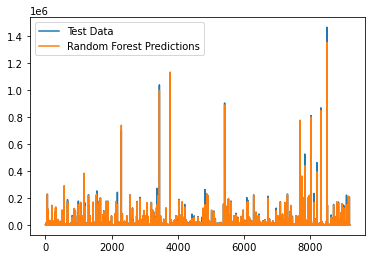

In [51]:
rf_estimator_pred = rf_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(rf_estimator_pred)
plt.legend(['Test Data', 'Random Forest Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, rf_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, rf_estimator_pred))

Text(0.5, 1.0, 'Average score: -1.0490297925708982')

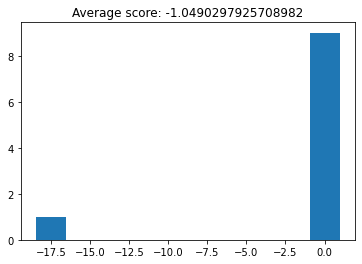

In [52]:
cv_scores = cross_val_score(rf_estimator, inputs, outputs, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [76]:
# Learning curve


train_sizes, train_scores, test_scores = learning_curve(estimator=rf_estimator, X=Inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True, 
                                       random_state=None, error_score=np.nan, return_times=False)

train_scores_mean = train_scores.mean(axis = 1)
test_scores_mean = test_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')

plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
title = 'Learning curves for a ' + str(rf_estimator).split('(')[0] + ' model'
plt.title(title, fontsize = 18, y = 1.03)
plt.legend()


NameError: name 'Inputs' is not defined

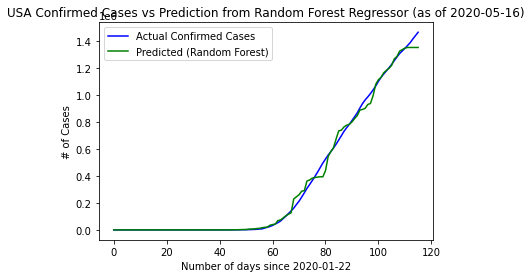

In [60]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = rf_estimator.predict(usa_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

In [ ]:
spain_df = df.loc[df["Country/Region"] == "Spain"]
spain_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
s_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = rf_estimator.predict(usa_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

In [ ]:
# do model with non normalized values, for comparison
inputs_non_norm = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs_non_norm

In [ ]:
# divide in training and testing sets
non_norm_in_conf_train, non_norm_in_conf_test, non_norm_out_conf_train, non_norm_out_conf_test = train_test_split(inputs_non_norm, outputs, test_size=0.25, shuffle=True)

In [ ]:
# create Random Forest Regressor instance, and check the hyper parameters
rf_non_norm = RandomForestRegressor()
rf_non_norm.get_params()

# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# search_non_norm = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search_non_norm = RandomizedSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

search_non_norm.fit(non_norm_in_conf_train, non_norm_out_conf_train)
print('Best score: {}'.format(search_non_norm.best_score_))
print('Best parameters: {}'.format(search_non_norm.best_params_))
search_non_norm.best_estimator_
rf_estimator_non_norm = search_non_norm.best_estimator_

In [ ]:
# rf_estimator_non_norm.fit(non_norm_in_conf_train, non_norm_out_conf_train)
rf_estimator_pred_non_norm = rf_estimator_non_norm.predict(non_norm_in_conf_test)
plt.plot(non_norm_out_conf_test)
plt.plot(rf_estimator_pred_non_norm)
plt.legend(['Test Data', 'Random Forest Predictions (Non Normalized)'])
print('MAE:', mean_absolute_error(non_norm_out_conf_test, rf_estimator_pred_non_norm))
print('MSE:',mean_squared_error(non_norm_out_conf_test, rf_estimator_pred_non_norm))

In [ ]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs_non_norm = usa_df[["Lat", "Long", "Num_days_from_begin"]].values
usa_pred_output_non_norm = rf_estimator_non_norm.predict(usa_inputs_non_norm)

plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output_non_norm, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction (Non normalized inputs) from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

In [ ]:
# matriz de confusao
# precision, recall, accuracy, F-measure


# fazer com inputs normalizados
# fazer com nao normalizados
# usar incrementos como output
# usar incrementos do dia anterior como input